The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 语义分割和数据集
:label:`sec_semantic_segmentation`

在 :numref:`sec_bbox`—:numref:`sec_rcnn` 中讨论物体检测任务时，矩形边界框用于标记和预测图像中的对象。本节将讨论 * 语义分割 * 的问题，重点介绍如何将图像划分为属于不同语义类的区域。与对象检测不同，语义分割可以识别并理解像素级别图像中的内容：其语义区域的标注和预测是以像素级别进行的。:numref:`fig_segmentation` 显示语义分割中图像的狗、猫和背景的标签。与对象检测相比，在语义分段中标记的像素级边框显然更加细粒度。 

![Labels of the dog, cat, and background of the image in semantic segmentation.](http://d2l.ai/_images/segmentation.svg)
:label:`fig_segmentation`

## 图像分割和实例分割

计算机视觉领域还有两项与语义分割类似的重要任务，即图像分割和实例分割。我们将简要区分它们与语义分割，如下所示。 

* * 图像分段 * 将图像划分为几个组成区域。解决此类问题的方法通常利用图像中像素之间的相关性。在训练过程中，它不需要有关图像像素的标签信息，也不能保证分段区域具有我们希望在预测过程中获得的语义。以 :numref:`fig_segmentation` 中的图像作为输入，图像分割可能会将狗分为两个区域：一个覆盖主要是黑色的嘴和眼睛，另一个覆盖主要是黄色的身体的其余部分。
* * 实例分段 * 也被称为 * 同时检测和分段 *。它研究如何识别图像中每个对象实例的像素级区域。与语义分割不同，实例分段不仅需要区分语义，还需要区分不同的对象实例。例如，如果图像中有两条狗，则实例分段需要区分一个像素所属的两只狗中的哪一只狗。

## Pascal VOC2012 语义分割数据集

[** 最重要的语义分割数据集之一是 [Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/).**] 在下面，我们将看看这个数据集。


In [1]:
%matplotlib inline
import os
from mxnet import gluon, image, np, npx
from d2l import mxnet as d2l

npx.set_np()


数据集的 tar 文件大约为 2 GB，因此下载该文件可能需要一段时间。提取的数据集位于 `../data/VOCdevkit/VOC2012`。


In [2]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

进入路径 `../data/VOCdevkit/VOC2012` 之后，我们可以看到数据集的不同组件。`ImageSets/Segmentation` 路径包含用于指定训练和测试样本的文本文件，而 `JPEGImages` 和 `SegmentationClass` 路径分别存储每个示例的输入图像和标签。此处的标签也采用图像格式，其大小与标记的输入图像大小相同。此外，任何标签图像中具有相同颜色的像素属于同一语义类。下面将 `read_voc_images` 函数定义为 [** 将所有输入图像和标签读入存储器 **]。


In [3]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(
            image.imread(os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(
            image.imread(
                os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png')))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

我们 [** 绘制前五个输入图像及其标签 **]。在标签图像中，白色和黑色分别表示边框和背景，而其他颜色对应于不同的类别。


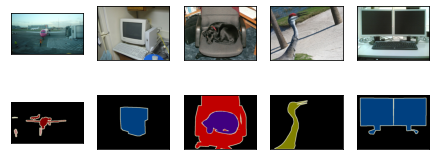

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

接下来，我们 [** 枚举此数据集中的所有标签的 RGB 颜色值和类名 **]。


In [5]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

通过上面定义的两个常量，我们可以方便地 [** 查找标签中每个像素的类索引 **]。我们定义了 `voc_colormap2label` 函数来构建从上述 RGB 颜色值到类索引的映射，而 `voc_label_indices` 函数将任何 RGB 值映射到此 Pascal VOC2012 数据集中的类索引。


In [6]:
#@save
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = np.zeros(256**3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 +
                       colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 +
           colormap[:, :, 2])
    return colormap2label[idx]

[** 例如 **]，在第一个示例图像中，飞机前部的类索引为 1，而背景索引为 0。


In [7]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]),
 'aeroplane')

### 数据预处理

在之前的实验中，例如 :numref:`sec_alexnet`—:numref:`sec_googlenet` 中，将重新缩放图像以适应模型所需的输入形状。但是，在语义分割中，这样做需要将预测的像素类重新缩放回输入图像的原始形状。这种调整可能不准确，特别是对于具有不同类别的分段区域。为避免此问题，我们将图像裁剪为 * 固定 * 形状，而不是重新缩放。具体来说，[** 使用图像扩充随机裁剪，我们裁剪输入图像和标签的相同区域 **]。


In [8]:
#@save
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

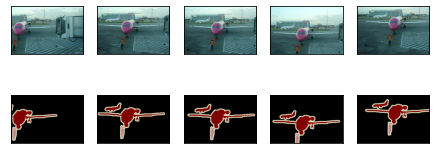

In [9]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### [** 自定义语义分段数据集类 **]

我们通过继承高级 API 提供的 `Dataset` 类来定义自定义语义分割数据集类 `VOCSegDataset`。通过实现 `__getitem__` 函数，我们可以任意访问数据集中索引为 `idx` 的输入图像以及该图像中每个像素的类索引。由于数据集中的某些图像的大小小小于随机裁剪的输出大小，因此通过自定义 `filter` 函数过滤掉这些示例。此外，我们还定义了 `normalize_image` 函数来标准化输入图像的三个 RGB 通道的值。


In [10]:
#@save
class VOCSegDataset(gluon.data.Dataset):
    """A customized dataset to load the VOC dataset."""
    def __init__(self, is_train, crop_size, voc_dir):
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [
            self.normalize_image(feature)
            for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [
            img for img in imgs if (img.shape[0] >= self.crop_size[0] and
                                    img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose(2, 0, 1),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### [** 阅读数据集 **]

我们使用自定义 `VOCSegDatase`t 类分别创建训练集和测试集的实例。假设我们指定随机裁剪图像的输出形状为 $320\times 480$。下面我们可以查看培训集和测试集中保留的示例数量。


In [11]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples


read 1078 examples


将批量大小设置为 64，我们定义培训集的数据加载器。让我们打印第一个迷你手表的形状。与图像分类或物体检测不同，这里的标签是三维张量。


In [12]:
batch_size = 64
train_iter = gluon.data.DataLoader(voc_train, batch_size, shuffle=True,
                                   last_batch='discard',
                                   num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


### [** 把所有东西放在一起 **]

最后，我们定义了以下 `load_data_voc` 函数来下载并读取 Pascal VOC2012 语义分割数据集。它返回训练和测试数据集的数据加载器。


In [13]:
#@save
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012',
                                   os.path.join('VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = gluon.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True,
        last_batch='discard', num_workers=num_workers)
    test_iter = gluon.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        last_batch='discard', num_workers=num_workers)
    return train_iter, test_iter

## 摘要

* 语义分割通过将图像划分为属于不同语义类的区域来识别并理解图像中的像素级别中的内容。
* 最重要的语义分割数据集之一是 Pascal VOC2012。
* 在语义分割中，由于输入图像和标签在像素上对应一对应，因此输入图像会随机裁剪为固定形状而不是重新缩放。

## 练习

1. 如何在自动驾驶车辆和医疗图像诊断中应用语义分割？你能想到其他应用程序吗？ 
1. 回想一下 :numref:`sec_image_augmentation` 中对数据增强的描述。图像分类中使用的哪种图像扩增方法不可行用于语义分割？


[Discussions](https://discuss.d2l.ai/t/375)
